In [ ]:
!unzip -q /content/models_predictions.zip -d /content/data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [ ]:
csv_dir = '/content/data/models_predictions'

## Create the data

In [ ]:
# Initialize a list to store the data with model information
data = []

# Loop over each CSV file in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith(".csv"):
        model_name = filename.replace(".csv", "")

        # Drop models that didn't work
        if model_name in ["google_gemma-2-27b", "google_gemma-2-27b-it"]:
          continue
        # Load the CSV file
        file_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(file_path)

        # handle too long model names
        if model_name == "nvidia_Llama-3.1-Nemotron-70B-Instruct-HF":
            model_name = "nvidia_Nemotron-70B-Instruct"

        # Add a 'model' column based on the filename
        df['model'] = '_'.join(model_name.split('_')[1:])

        # Append to the list
        data.append(df)

# Concatenate all data into a single DataFrame
all_data = pd.concat(data, ignore_index=True)
all_data['is_correct_prediction'] = all_data['correct_probability'] > all_data['incorrect_probability']
all_data = all_data.sort_values(
    by=['model', 'type'],
    key=lambda col: col.str.lower()
)



In [ ]:
# All the types
all_data["type"].unique()

array(['first_center_com', 'first_center_mid', 'first_center_sim',
       'first_center_sim_rev', 'second_center_com', 'second_center_mid',
       'second_center_sim', 'second_center_sim_rev'], dtype=object)

In [ ]:
all_data['center_type'] = all_data['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
all_data['wording'] = all_data['type'].apply( lambda x: 'com' if x.endswith('com') else
              ('mid' if x.endswith('mid') else
               ('sim' if x.endswith('sim') else
                ('sim_rev' if x.endswith('sim_rev') else 'non_com'))
              ))

In [ ]:
with_sim_rev = all_data.copy()

In [ ]:
all_data = all_data[~all_data["type"].isin(["first_center_sim_rev", "second_center_sim_rev"])]

In [ ]:
all_data.sort_values(by=["set_id", "model"]).head(16)

sentence  \
1                                      The child that the neighbor that the guest scared liked fell.   
3                                The child, who was liked by the neighbor scared by the guest, fell.   
5     There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.   
0                                      The child that the neighbor that the guest scared liked fell.   
2                                The child, who was liked by the neighbor scared by the guest, fell.   
4     There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.   
2257                                   The child that the neighbor that the guest scared liked fell.   
2259                             The child, who was liked by the neighbor scared by the guest, fell.   
2261  There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.   
2256                                   The child that the neighbor that the guest scared liked fell.   
2258                             The child, who was liked by the neighbor scared by the guest, fell.   
2260  There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.   
3761                                   The child that the neighbor that the guest scared liked fell.   
3763                             The child, who was liked by the neighbor scared by the guest, fell.   
3765  There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.   
3760                                   The child that the neighbor that the guest scared liked fell.   

                        question  set_id               type        answer  \
1     Who did the neighbor like?       1   first_center_com     The child   
3     Who did the neighbor like?       1   first_center_mid     The child   
5     Who did the neighbor like?       1   first_center_sim     The child   
0       Who did the guest scare?       1  second_center_com  The neighbor   
2       Who did the guest scare?       1  second_center_mid  The neighbor   
4       Who did the guest scare?       1  second_center_sim  The neighbor   
2257  Who did the neighbor like?       1   first_center_com     The child   
2259  Who did the neighbor like?       1   first_center_mid     The child   
2261  Who did the neighbor like?       1   first_center_sim     The child   
2256    Who did the guest scare?       1  second_center_com  The neighbor   
2258    Who did the guest scare?       1  second_center_mid  The neighbor   
2260    Who did the guest scare?       1  second_center_sim  The neighbor   
3761  Who did the neighbor like?       1   first_center_com     The child   
3763  Who did the neighbor like?       1   first_center_mid     The child   
3765  Who did the neighbor like?       1   first_center_sim     The child   
3760    Who did the guest scare?       1  second_center_com  The neighbor   

     correct_option  correct_first_token  correct_probability  \
1             child                 3124             0.511717   
3             child                 3124             0.953622   
5             child                 3124             0.959154   
0          neighbor                37569             0.258326   
2          neighbor                37569             0.307358   
4          neighbor                37569             0.846958   
2257          child                 3124             0.384912   
2259          child                 3124             0.626124   
2261          child                 3124             0.875787   
2256       neighbor                37569             0.501953   
2258       neighbor                37569             0.550607   
2260       neighbor                37569             0.288569   
3761          child                 3124             0.470737   
3763          child                 3124             0.993612   
3765          child                 31

In [ ]:
intro_data = all_data[all_data["model"].isin(["gemma-2-2b", "gemma-2-2b-it", "gemma-2-9b", "gemma-2-9b-it", "vicuna-13b-v1.5", "vicuna-7b-v1.5", "Llama-3.2-1B", "Llama-3.2-1B-Instruct"])]

In [ ]:
def create_groupby(df):
  accuracy_by_model_and_type = (
      df
      .groupby(['model', 'type'])['is_correct_prediction']
      .mean()
      .reset_index()
      .rename(columns={'is_correct_prediction': 'accuracy'})
  )
  # Case-insensitive sorting by multiple columns (e.g., 'model' and 'type')
  accuracy_by_model_and_type = accuracy_by_model_and_type.sort_values(
      by=['model', 'type'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)


  # Extract center type and suffix from the `type` column
  accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
  accuracy_by_model_and_type['wording'] = accuracy_by_model_and_type['type'].apply(
      lambda x: 'com' if x.endswith('com') else
                ('mid' if x.endswith('mid') else
                ('sim' if x.endswith('sim') else
                  ('sim_rev' if x.endswith('sim_rev') else 'non_com')))
  )
  return accuracy_by_model_and_type

accuracy_by_model_and_type = create_groupby(all_data)
accuracy_by_model_and_type_with_sim_rev = create_groupby(with_sim_rev)


In [ ]:
accuracy_by_model_and_type.head()

model               type  accuracy    center_type wording
0  gemma-2-2b   first_center_com  0.914894   first_center     com
1  gemma-2-2b   first_center_mid  0.872340   first_center     mid
2  gemma-2-2b   first_center_sim  0.914894   first_center     sim
3  gemma-2-2b  second_center_com  0.191489  second_center     com
4  gemma-2-2b  second_center_mid  0.468085  second_center     mid

In [ ]:
intro_data = accuracy_by_model_and_type[accuracy_by_model_and_type["model"].isin(["gemma-2-2b", "gemma-2-2b-it", "gemma-2-9b", "gemma-2-9b-it", "vicuna-13b-v1.5", "vicuna-7b-v1.5", "Llama-3.2-1B", "Llama-3.2-1B-Instruct"])]

In [ ]:
res_dir = "/content/res"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

## General

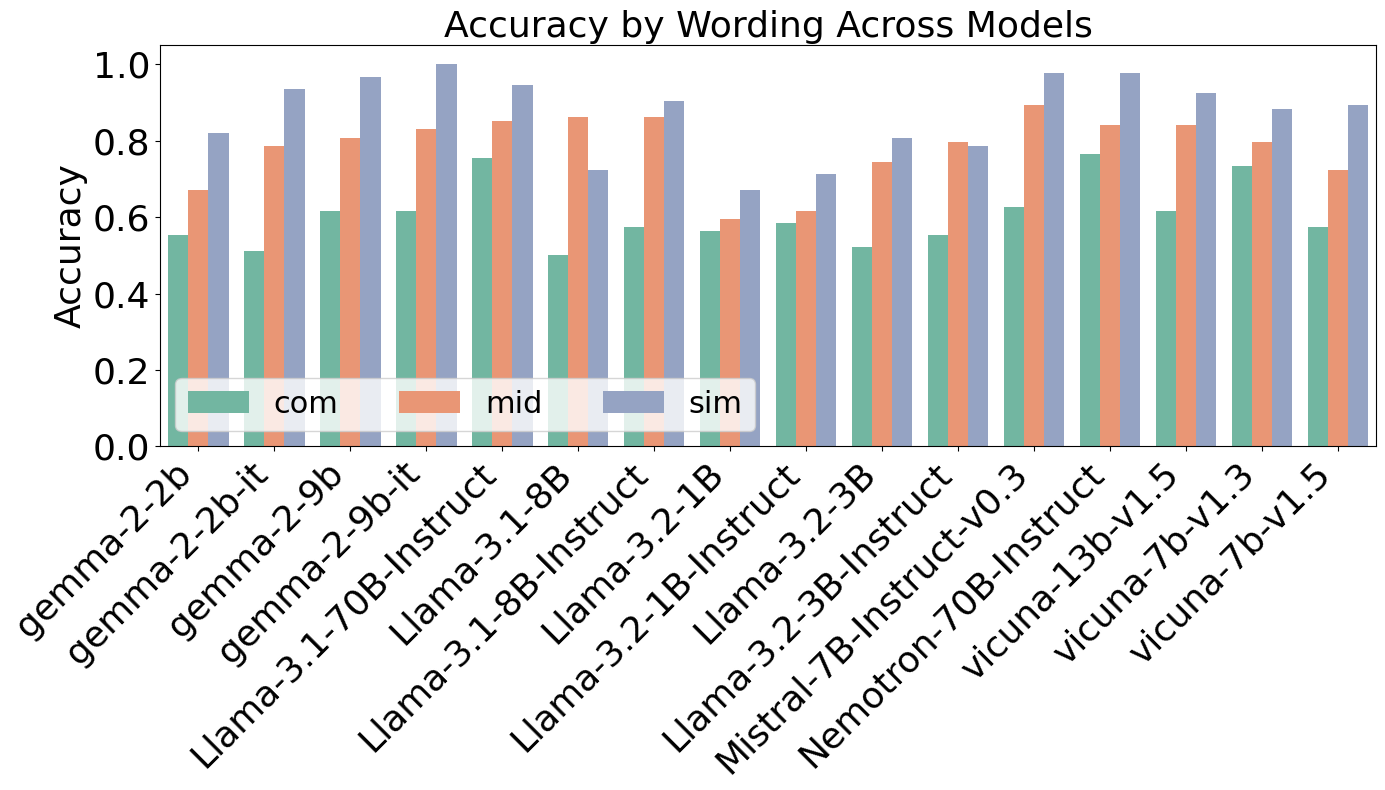

In [ ]:
# Extract center type and suffix from the `type` column
#accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
#accuracy_by_model_and_type['suffix'] = accuracy_by_model_and_type['type'].apply(lambda x: '_'.join(x.split('_')[2:]))

# Calculate the average accuracy for each model, center type, and suffix
avg_accuracy = accuracy_by_model_and_type.groupby(['model', 'wording'])['accuracy'].mean().reset_index()
avg_accuracy = avg_accuracy.sort_values(
    by=['model', 'wording'],
    key=lambda col: col.str.lower(),
).reset_index(drop=True)

# Set up the figure
plt.figure(figsize=(14, 8))

# Create the bar plot
sns.barplot(
    data=avg_accuracy,
    x='model',
    y='accuracy',
    hue='wording',  # Combining center type and suffix for color coding
    palette='Set2'
)

# Customize the plot
title = 'Accuracy by Wording Across Models'
plt.title(title, fontsize='26')
plt.xlabel('')
plt.ylabel('Accuracy', fontsize='26')
plt.legend(loc='lower left', fontsize='22', ncol=3)
plt.xticks(rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)

# Save figure
filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
file_path = os.path.join(res_dir, filename)
plt.savefig(file_path)


# Show plot
plt.tight_layout()
plt.show()

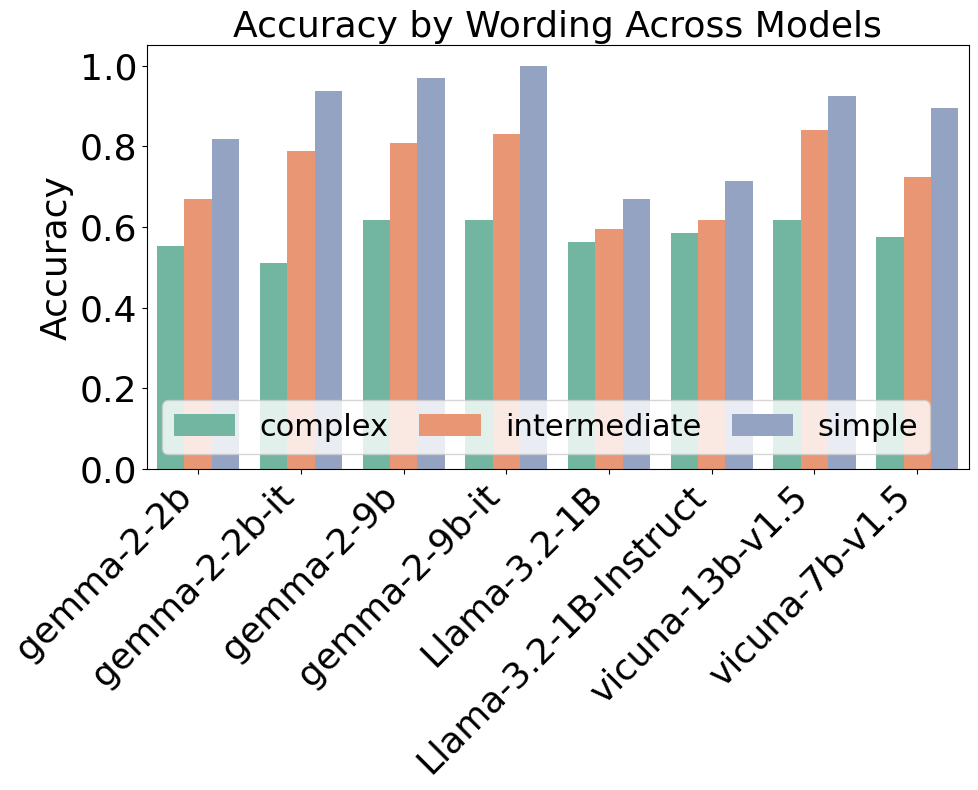

In [ ]:
avg_accuracy = intro_data.groupby(['model', 'wording'])['accuracy'].mean().reset_index()
avg_accuracy = avg_accuracy.sort_values(
    by=['model', 'wording'],
    key=lambda col: col.str.lower(),
).reset_index(drop=True)

avg_accuracy['wording'] = avg_accuracy['wording'].replace({
    'sim': 'simple',
    'com': 'complex',
    'mid': 'intermediate'
})

# Set up the figure
plt.figure(figsize=(10, 8))

# Create the bar plot
sns.barplot(
    data=avg_accuracy,
    x='model',
    y='accuracy',
    hue='wording',  # Combining center type and suffix for color coding
    palette='Set2'
)

# Customize the plot
title = 'Accuracy by Wording Across Models'
plt.title(title, fontsize='26')
plt.xlabel('')
plt.ylabel('Accuracy', fontsize='26')
plt.legend(loc='lower left', fontsize='22', ncol=3, columnspacing=1)
plt.xticks(rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)

# Save figure
filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
file_path = os.path.join(res_dir, filename)
plt.savefig(file_path)


# Show plot
plt.tight_layout()
plt.show()

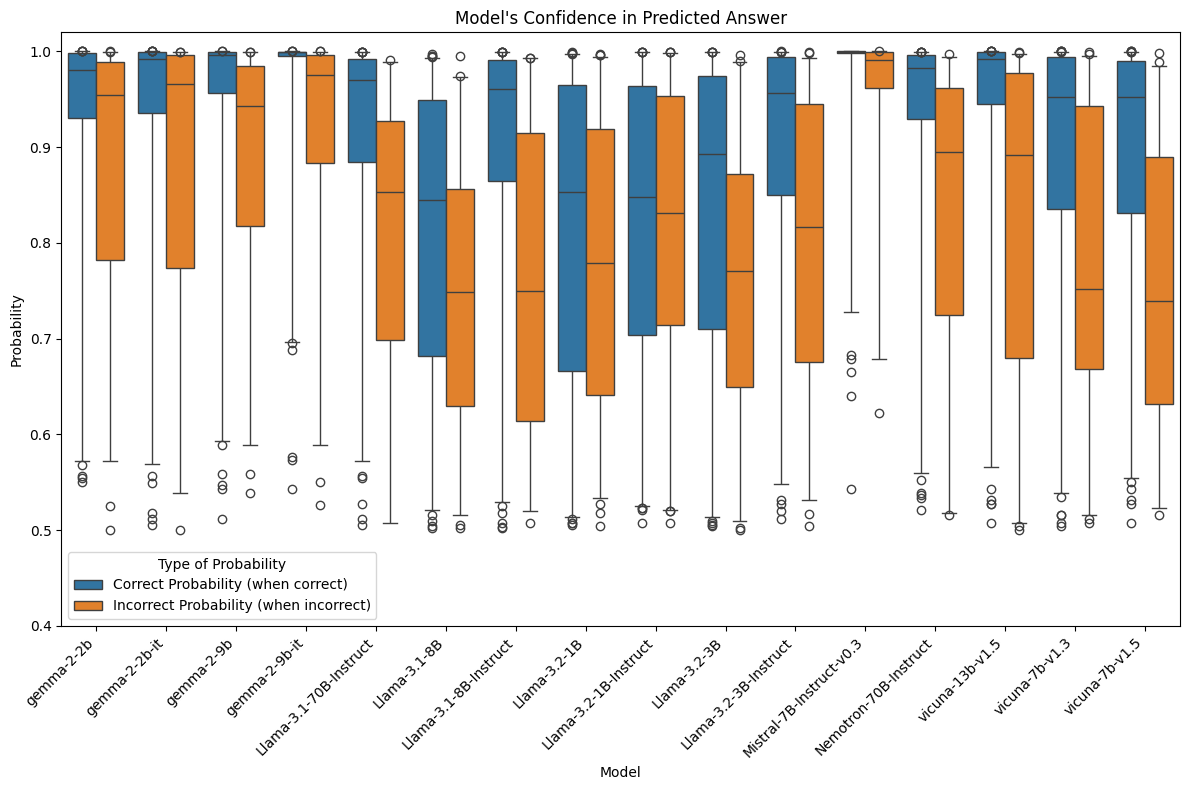

In [ ]:
# Filter data for correct and incorrect predictions
correct_data = all_data[all_data['is_correct_prediction'] == True][['model', 'correct_probability']]
incorrect_data = all_data[all_data['is_correct_prediction'] == False][['model', 'incorrect_probability']]

# Rename columns for consistency in plotting
correct_data = correct_data.rename(columns={'correct_probability': 'probability'})
incorrect_data = incorrect_data.rename(columns={'incorrect_probability': 'probability'})

# Add a column indicating the type of probability
correct_data['type'] = 'Correct Probability (when correct)'
incorrect_data['type'] = 'Incorrect Probability (when incorrect)'

# Combine the two datasets
plot_data = pd.concat([correct_data, incorrect_data], ignore_index=True)
plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(
    data=plot_data,
    x='model',
    y='probability',
    hue='type',
    dodge=True,
    whis=[2,98]
)
plt.title('Model\'s Confidence in Predicted Answer')
plt.xlabel('Model')
plt.ylabel('Probability')
plt.legend(title='Type of Probability')
plt.ylim(0.4,1.02)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
plot_data.head()

model  probability                                type
0  gemma-2-2b     0.837620  Correct Probability (when correct)
1  gemma-2-2b     0.916708  Correct Probability (when correct)
2  gemma-2-2b     0.991084  Correct Probability (when correct)
3  gemma-2-2b     0.930458  Correct Probability (when correct)
4  gemma-2-2b     0.554470  Correct Probability (when correct)

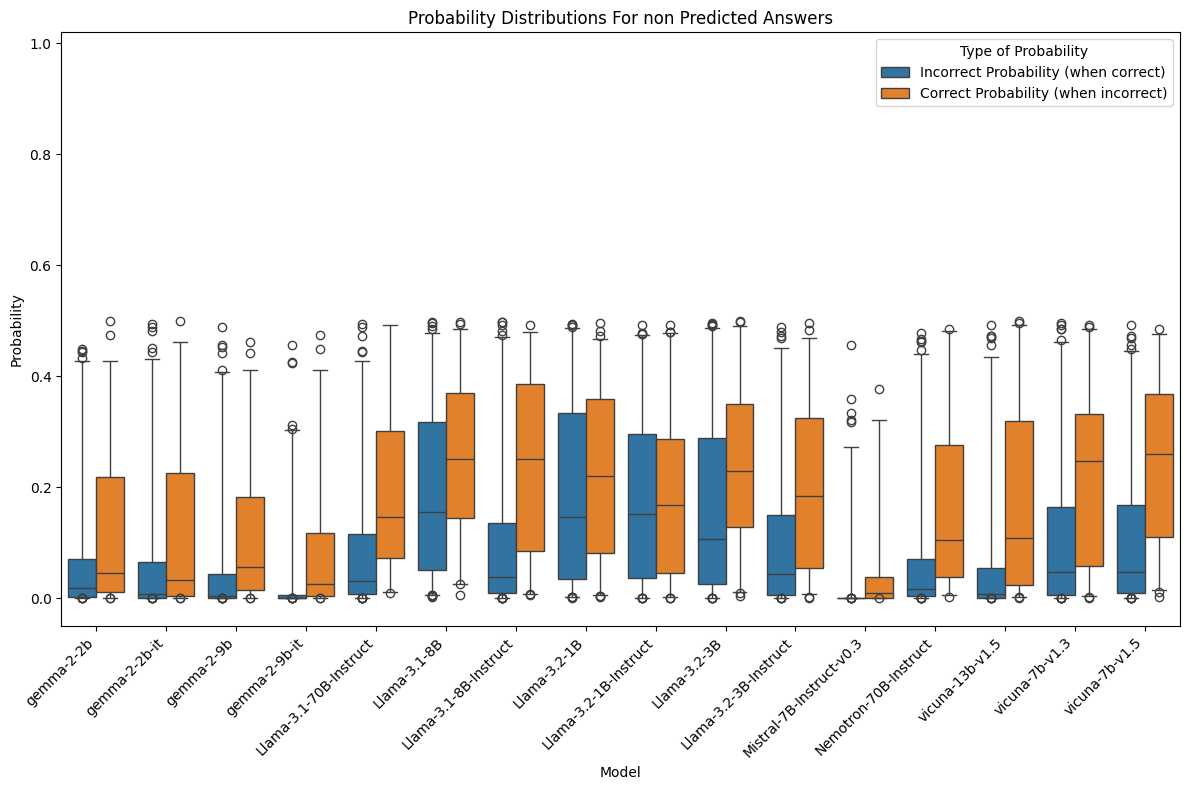

In [ ]:
# Filter data for correct and incorrect predictions
correct_data = all_data[all_data['is_correct_prediction'] == True][['model', 'incorrect_probability']]
incorrect_data = all_data[all_data['is_correct_prediction'] == False][['model', 'correct_probability']]

# Rename columns for consistency in plotting
correct_data = correct_data.rename(columns={'incorrect_probability': 'probability'})
incorrect_data = incorrect_data.rename(columns={'correct_probability': 'probability'})

# Add a column indicating the type of probability
correct_data['type'] = 'Incorrect Probability (when correct)'
incorrect_data['type'] = 'Correct Probability (when incorrect)'

# Combine the two datasets
plot_data = pd.concat([correct_data, incorrect_data], ignore_index=True)
plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(
    data=plot_data,
    x='model',
    y='probability',
    hue='type',
    dodge=True,
    whis=[2,98]
)
plt.title('Probability Distributions For non Predicted Answers')
plt.xlabel('Model')
plt.ylabel('Probability')
plt.legend(title='Type of Probability')
plt.ylim(-0.05,1.02)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Com vs Non-Com

<ipython-input-24-6a25def9e279>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


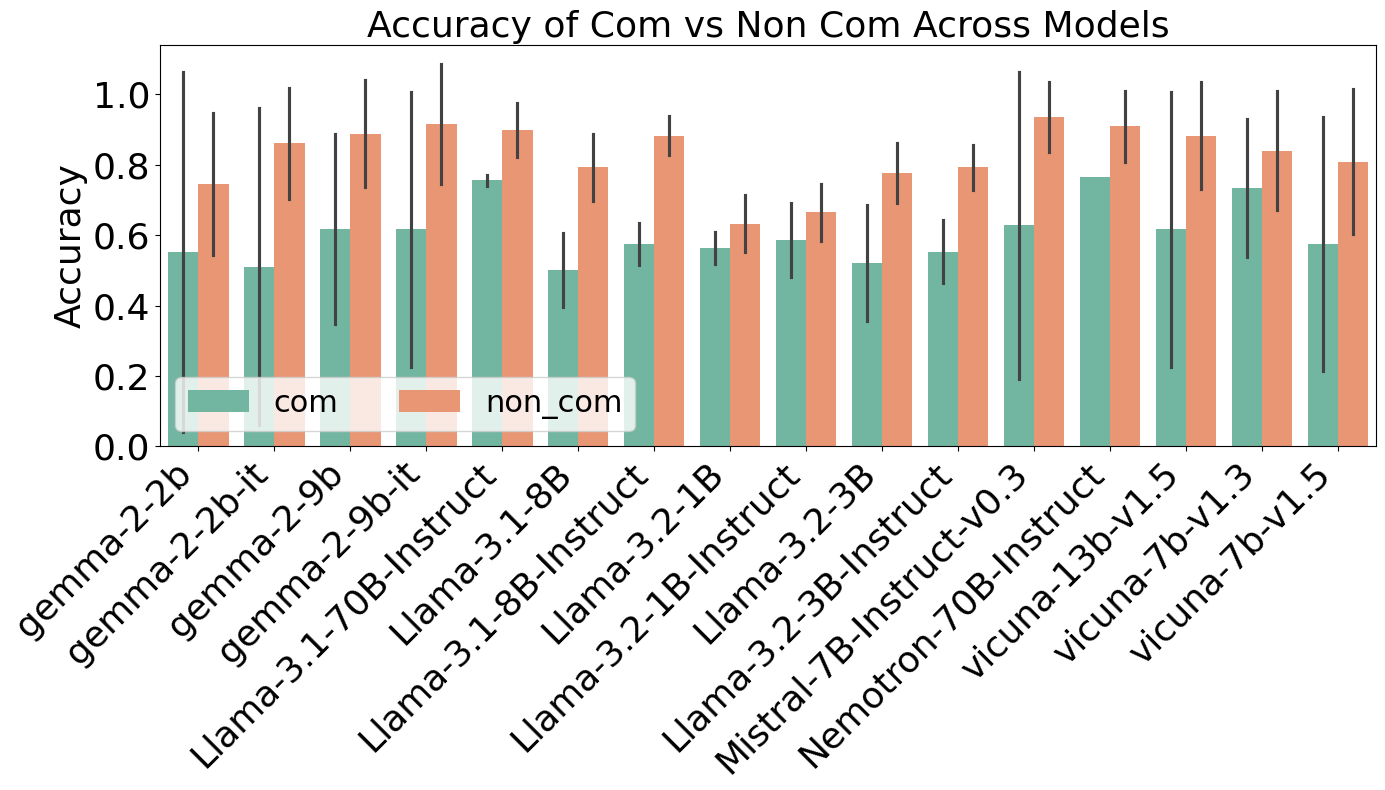

<ipython-input-24-6a25def9e279>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


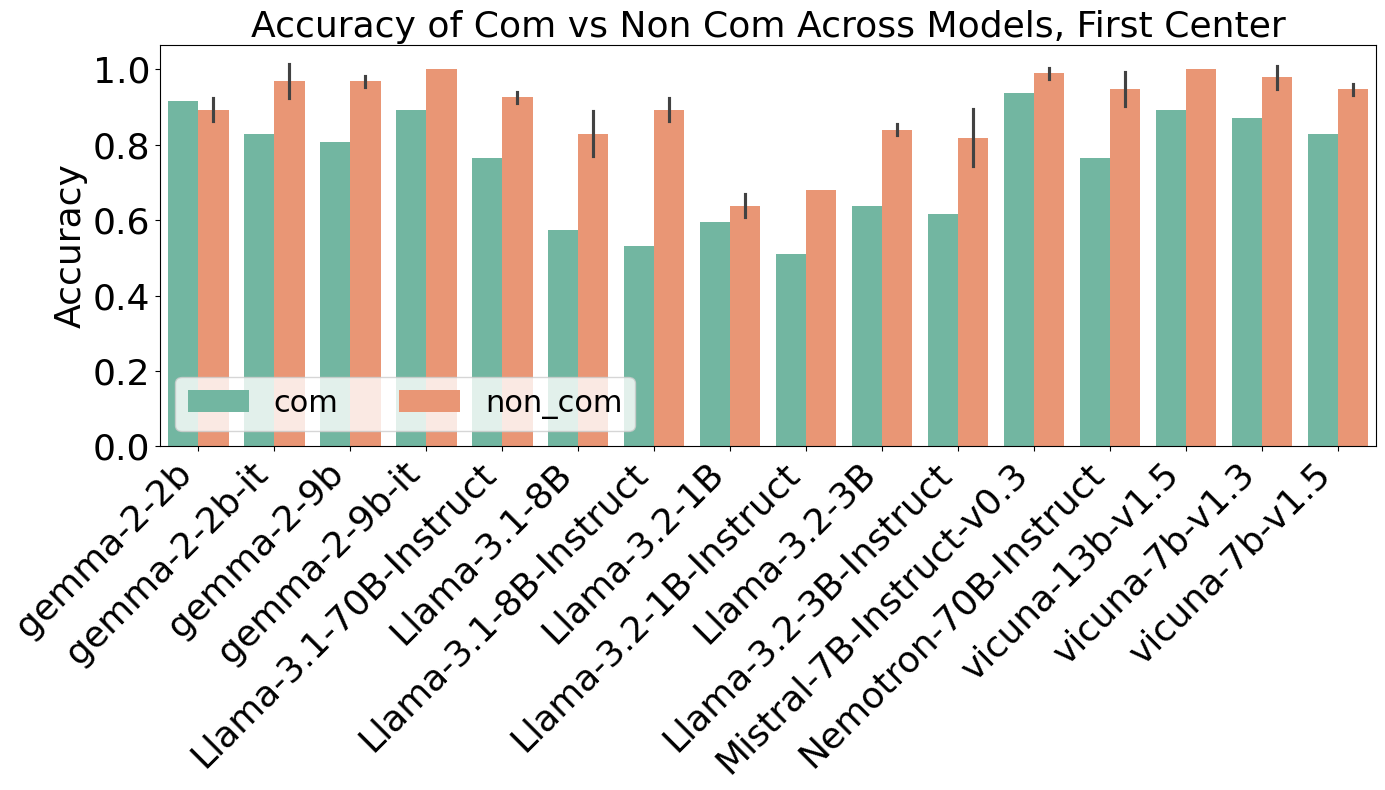

<ipython-input-24-6a25def9e279>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


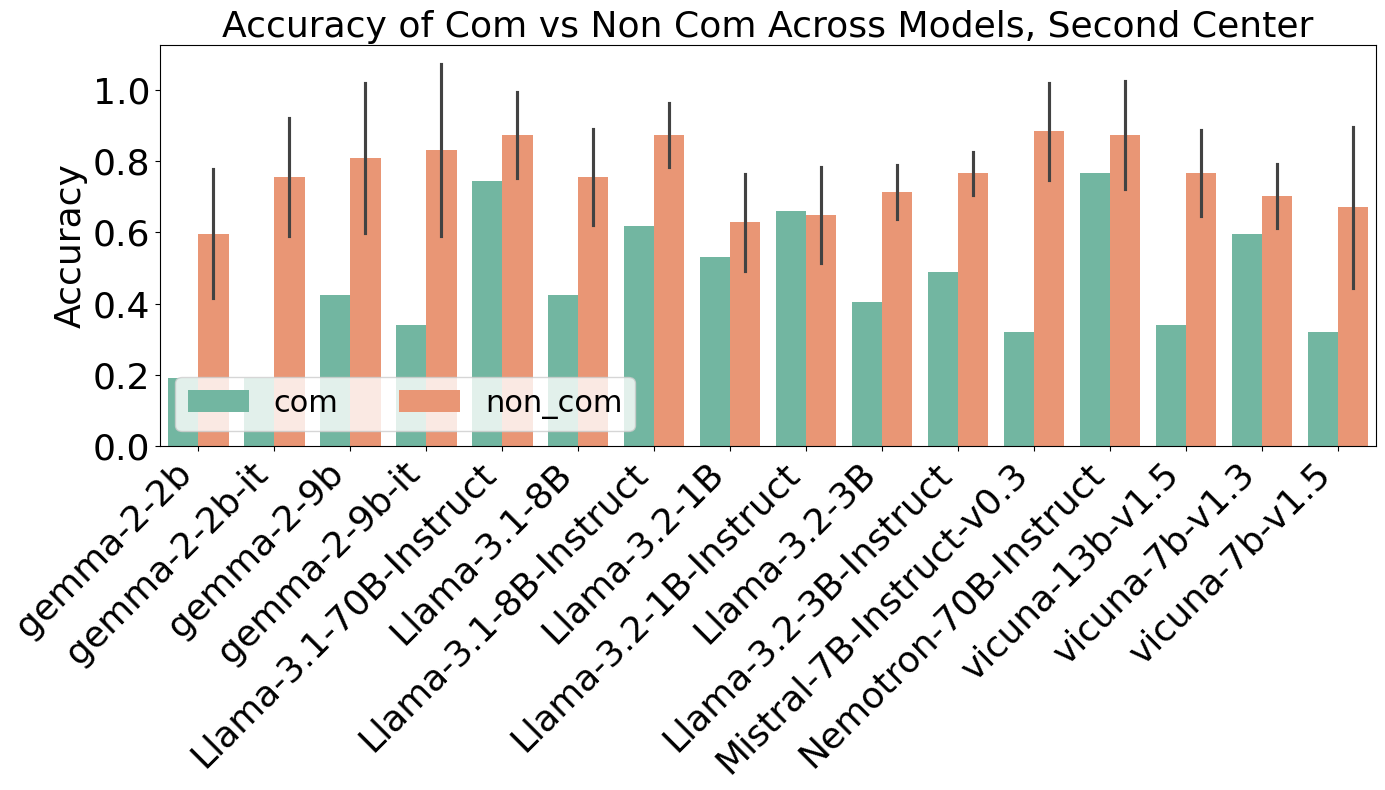

In [ ]:
# Draw accuracy separated by center

# Extract center type and suffix from the `type` column
accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
accuracy_by_model_and_type['wording_com'] = accuracy_by_model_and_type['type'].apply(lambda x: 'com' if 'com' in x else 'non_com')

def plot_accuracy_per_model(grouped_df, title, with_error_bars=True):

  # Calculate the average accuracy for each model, center type, and suffix
  avg_accuracy = grouped_df.groupby(['model', 'wording_com'])['accuracy'].mean().reset_index()
  avg_accuracy = avg_accuracy.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the figure
  plt.figure(figsize=(14, 8))

  # Create the bar plot
  if not with_error_bars:
    sns.barplot(
        data=avg_accuracy,
        x='model',
        y='accuracy',
        hue='wording_com',  # Combining center type and wording for color coding
        palette='Set2'
    )
  else:
    sns.barplot(
        data=grouped_df,
        x='model',
        y='accuracy',
        hue='wording_com',  # Combining center type and wording for color coding
        palette='Set2',
        ci='sd'
    )

  # Customize the plot
  plt.title(title, fontsize=26)
  plt.xlabel('')
  plt.ylabel('Accuracy', fontsize=26)
  plt.legend(loc='lower left', fontsize=22, ncols=2)
  plt.xticks(rotation=45, ha='right', fontsize=26)
  plt.yticks(fontsize=26)

  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)

  # Show plot
  plt.tight_layout()
  plt.show()

plot_accuracy_per_model(accuracy_by_model_and_type, 'Accuracy of Com vs Non Com Across Models')
first_center = accuracy_by_model_and_type[accuracy_by_model_and_type['center_type'] == "first_center"]
second_center = accuracy_by_model_and_type[accuracy_by_model_and_type['center_type'] == "second_center"]
plot_accuracy_per_model(first_center, title='Accuracy of Com vs Non Com Across Models, First Center')
plot_accuracy_per_model(second_center, title='Accuracy of Com vs Non Com Across Models, Second Center')

In [ ]:
def confidence_com_non_com(all_data, isRight, filter= None):
  title_end=" (Com vs Non Com)"
  if filter== "first":
    all_data=all_data[all_data['center_type'] == 'first_center']
    title_end= " First Center"
  elif filter== "second":
     all_data=all_data[all_data['center_type'] == 'second_center']
     title_end= " Second Center"
  # Filter data for correct and incorrect predictions
  prob = 'correct_probability' if isRight else 'incorrect_probability'
  com_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['wording'] == 'com')][['model', prob]]
  non_com_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['wording'].isin(['sim', 'mid']))][['model', prob]]

  # Rename columns for consistency in plotting
  com_data = com_data.rename(columns={prob: 'probability'})
  non_com_data = non_com_data.rename(columns={prob: 'probability'})

  # Add a column indicating the type of probability
  com_data['type'] = 'Com'
  non_com_data['type'] = 'Non Com'

  # Combine the two datasets
  plot_data = pd.concat([com_data, non_com_data], ignore_index=True)
  plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the matplotlib figure
  plt.figure(figsize=(12, 8))

  # Create a boxplot
  sns.boxplot(
      data=plot_data,
      x='model',
      y='probability',
      hue='type',
      dodge=True,
      whis=[2,98]
  )
  is_right_title= "Right Answers" if isRight else "Wrong Answers"
  title= 'Confidence on ' + is_right_title + title_end
  plt.title(title, fontsize=26)
  plt.xlabel('')
  plt.ylabel('Distribution', fontsize=26)
  plt.legend(ncols=2, fontsize=22, loc='lower left')
  plt.ylim(0.4,1.02)
  plt.xticks(rotation=45, ha='right', fontsize=26)
  plt.yticks(fontsize=26)


  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)


  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()



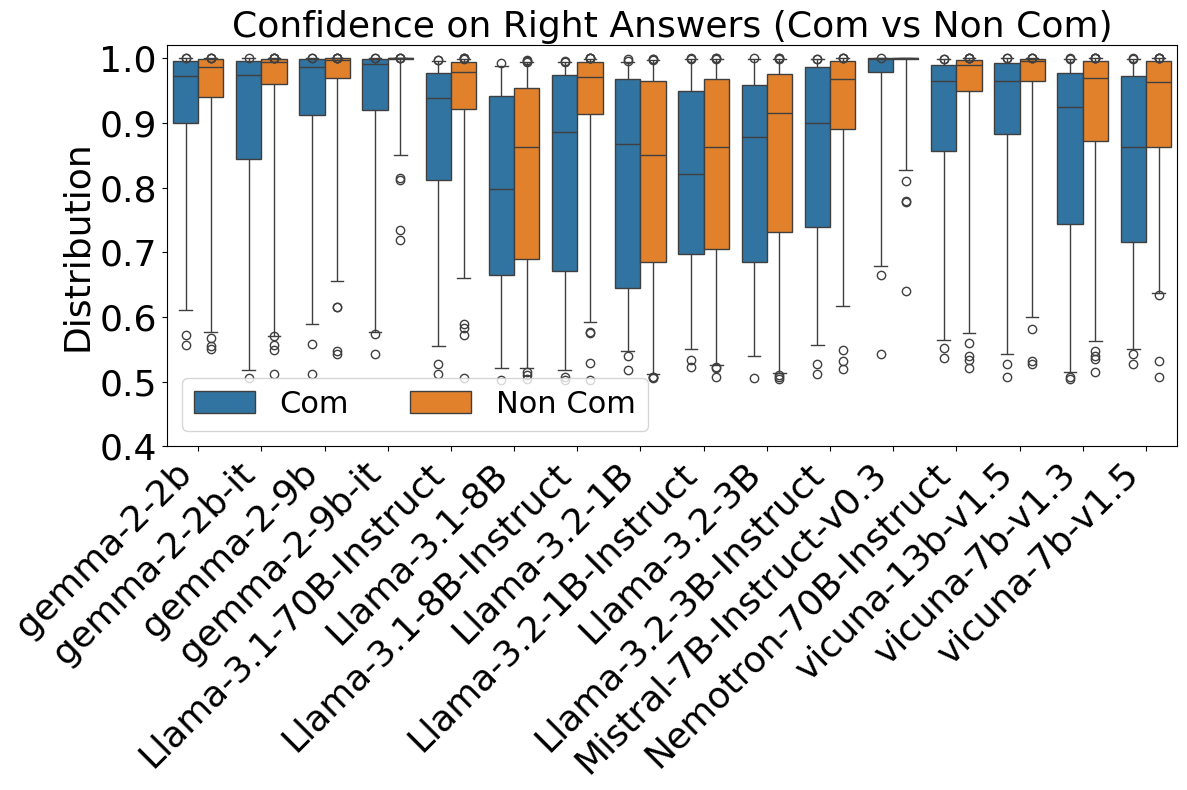

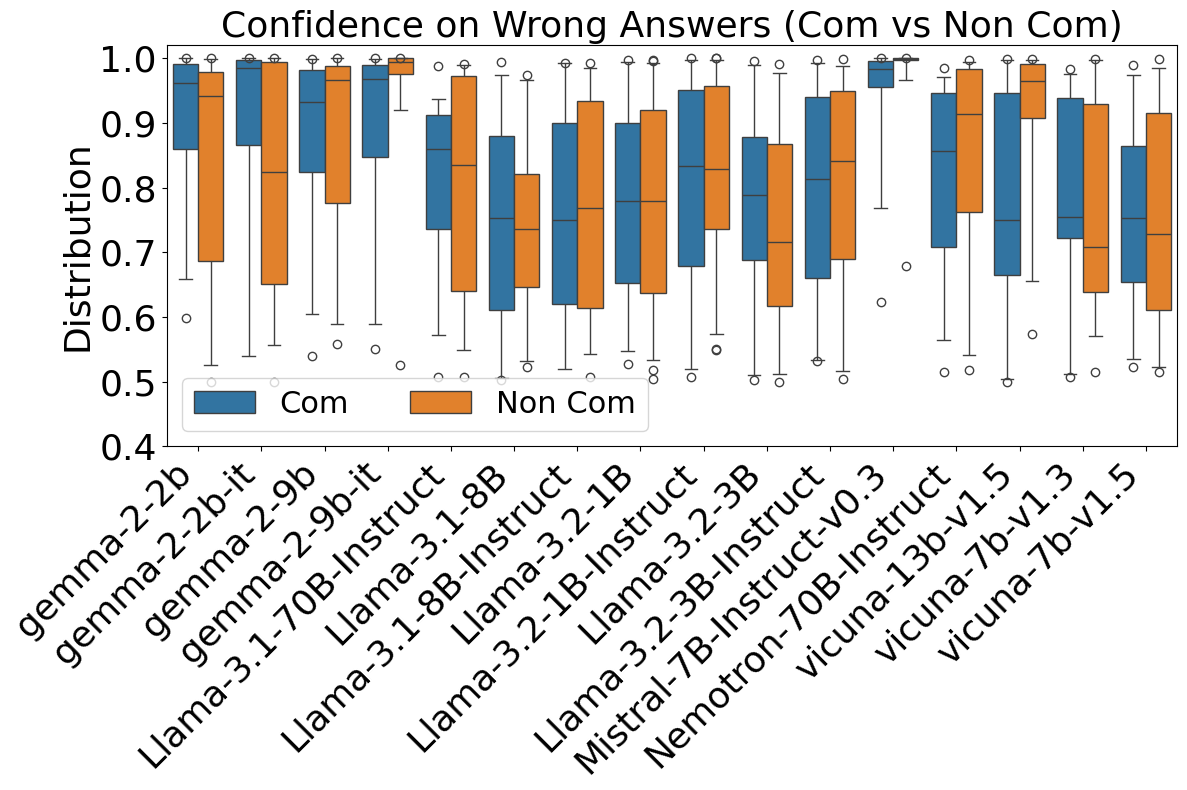

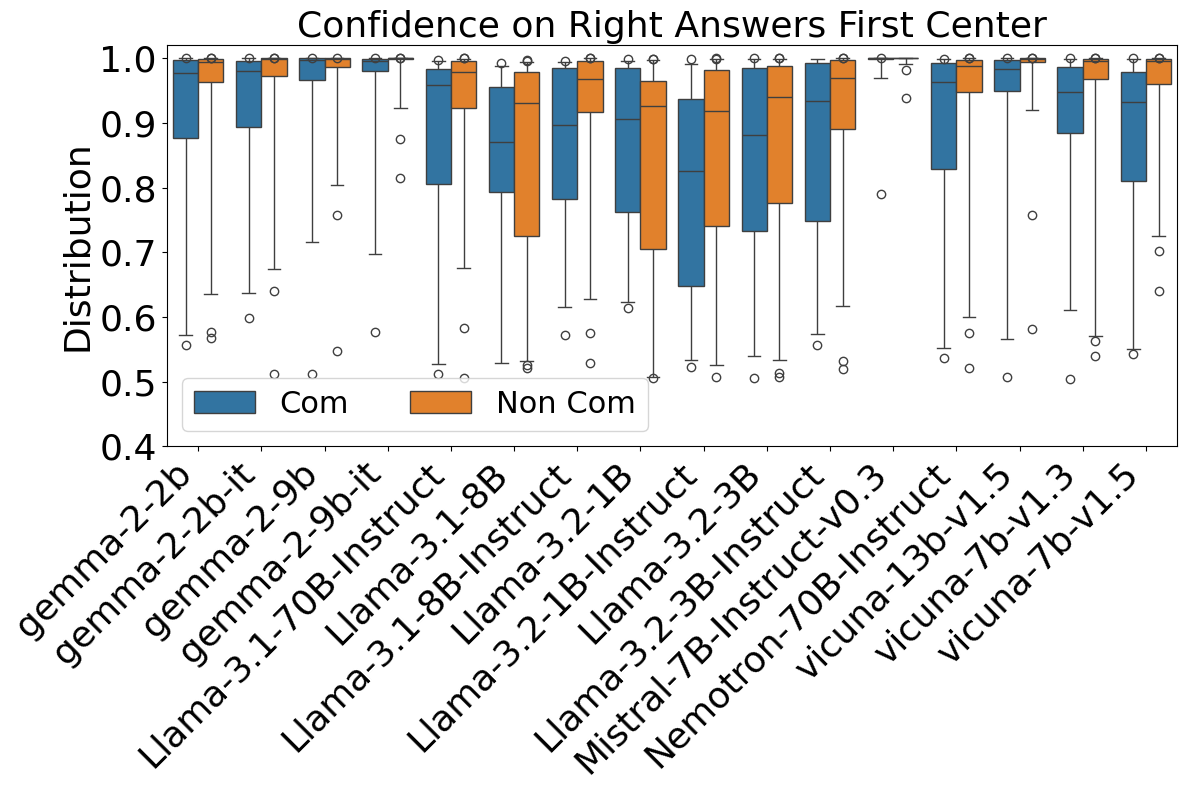

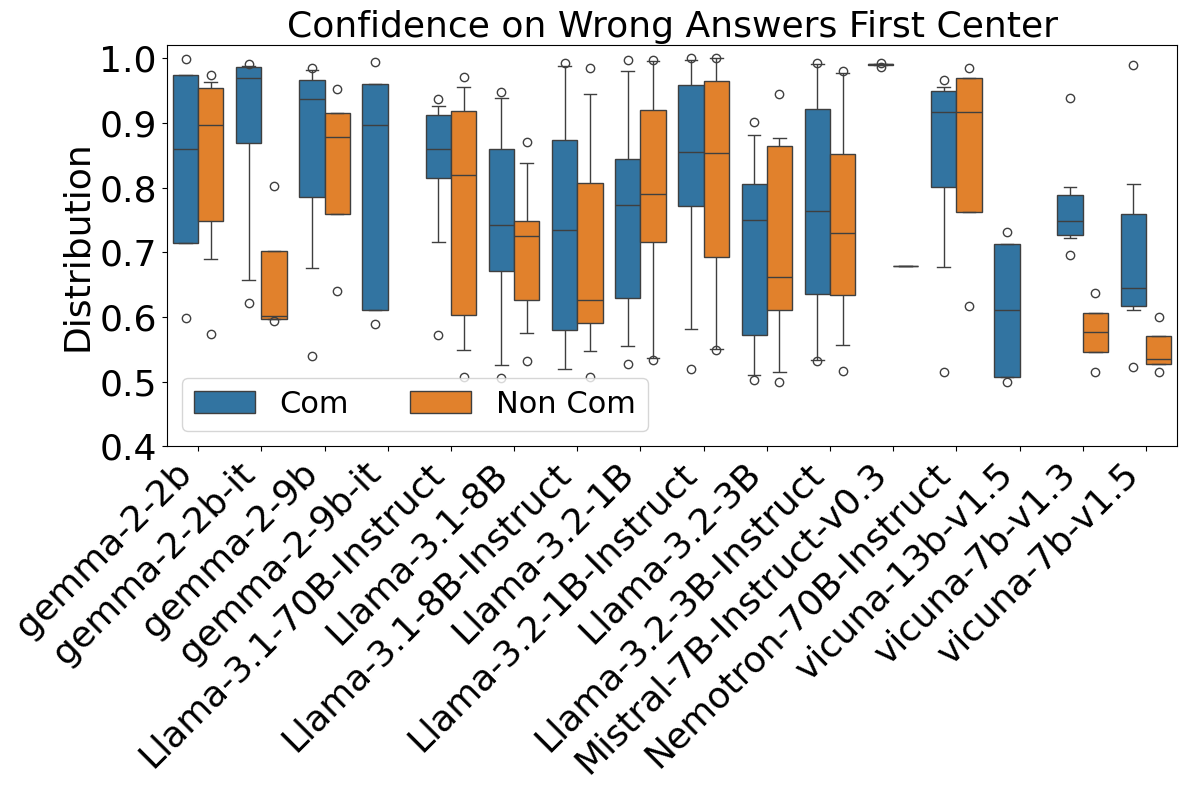

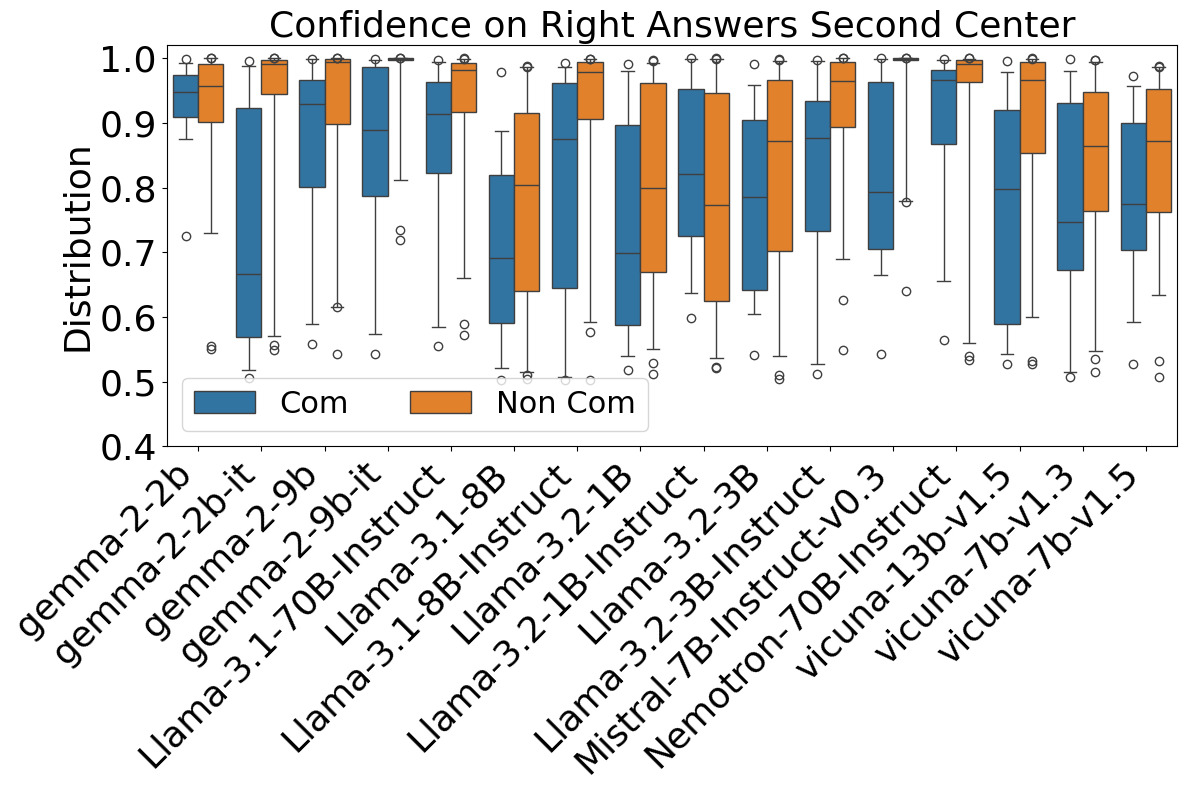

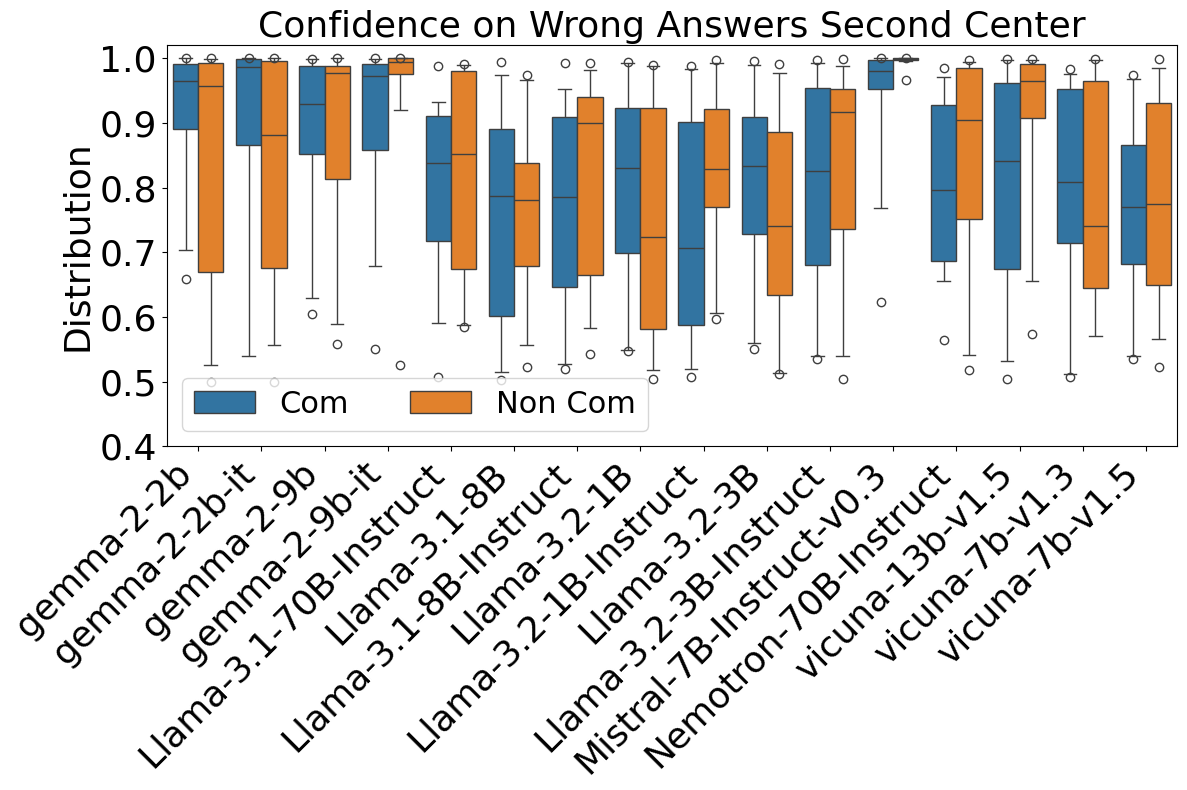

In [ ]:

confidence_com_non_com(all_data=all_data,isRight=True)
confidence_com_non_com(all_data=all_data,isRight=False)
confidence_com_non_com(all_data=all_data, isRight=True,filter= "first")
confidence_com_non_com(all_data=all_data, isRight=False, filter="first")
confidence_com_non_com(all_data=all_data, isRight=True, filter="second")
confidence_com_non_com(all_data=all_data, isRight=False, filter="second")



## First Center vs Second Center

In [ ]:
accuracy_by_model_and_type.head()

model               type  accuracy    center_type wording wording_com
0  gemma-2-2b   first_center_com  0.914894   first_center     com         com
1  gemma-2-2b   first_center_mid  0.872340   first_center     mid     non_com
2  gemma-2-2b   first_center_sim  0.914894   first_center     sim     non_com
3  gemma-2-2b  second_center_com  0.191489  second_center     com         com
4  gemma-2-2b  second_center_mid  0.468085  second_center     mid     non_com

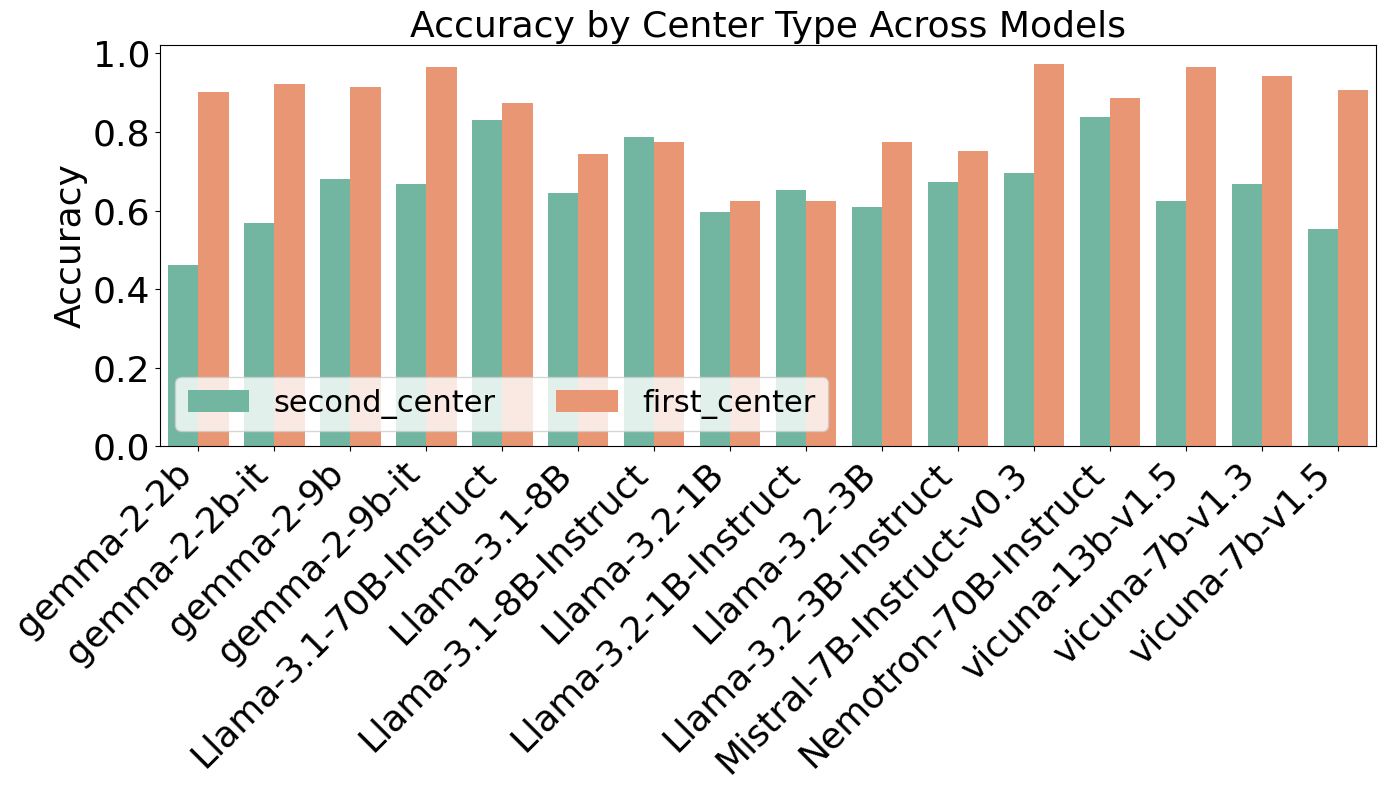

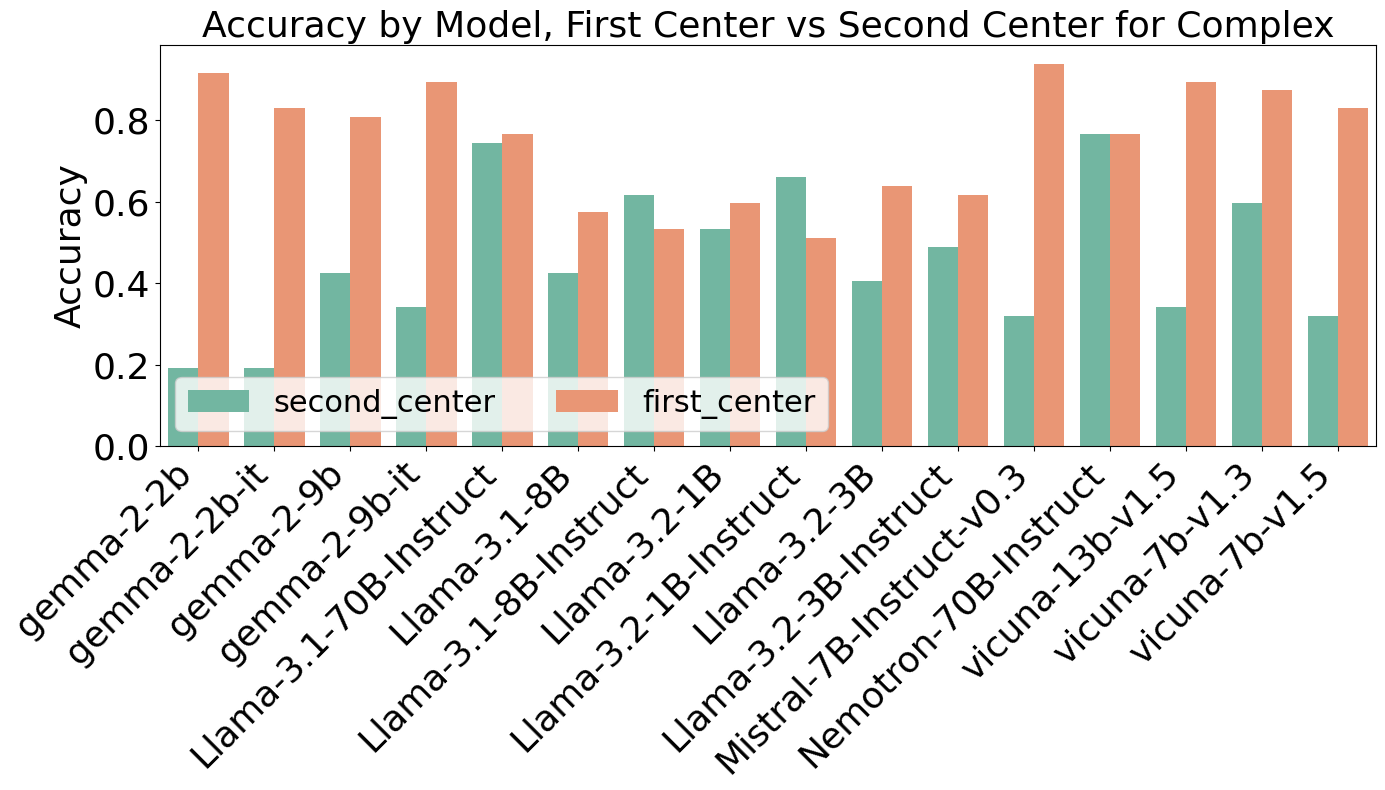

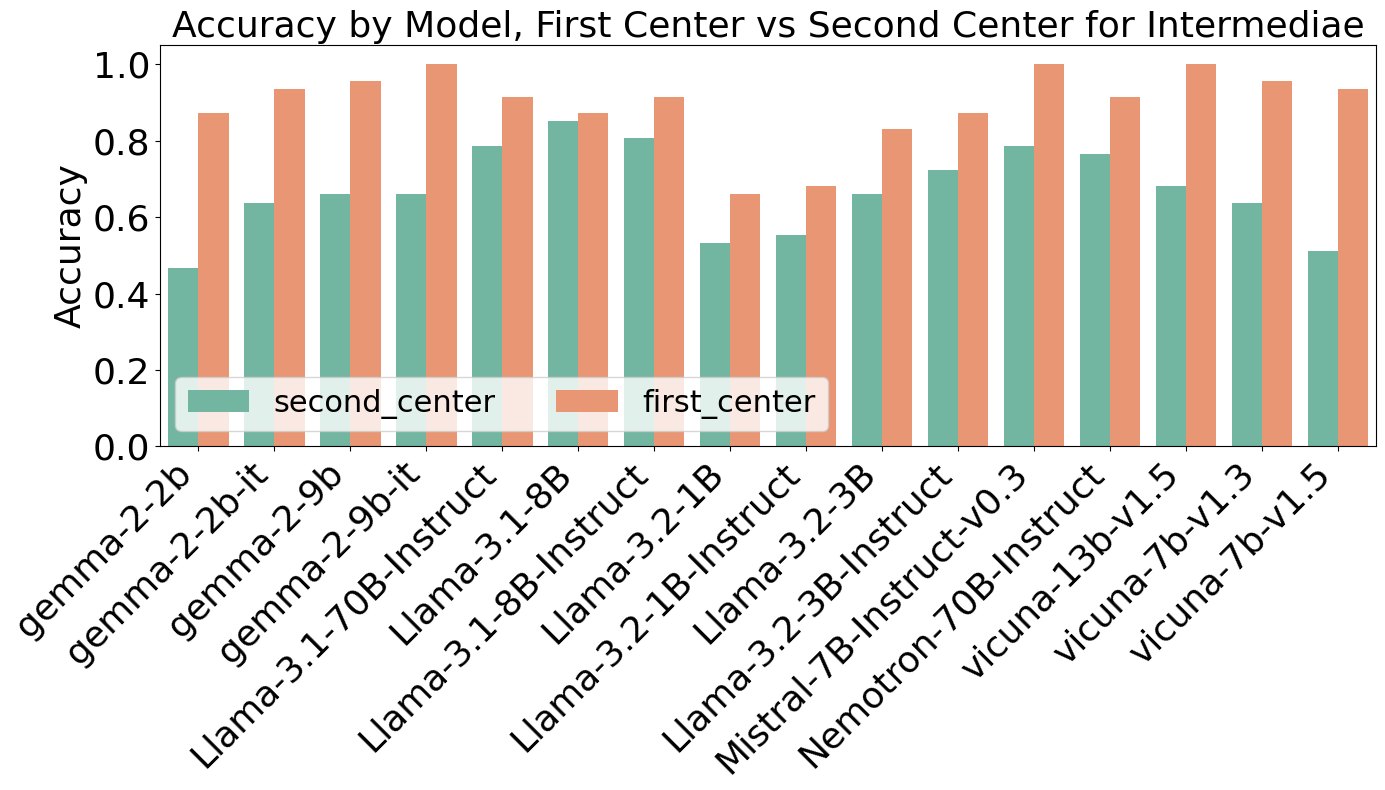

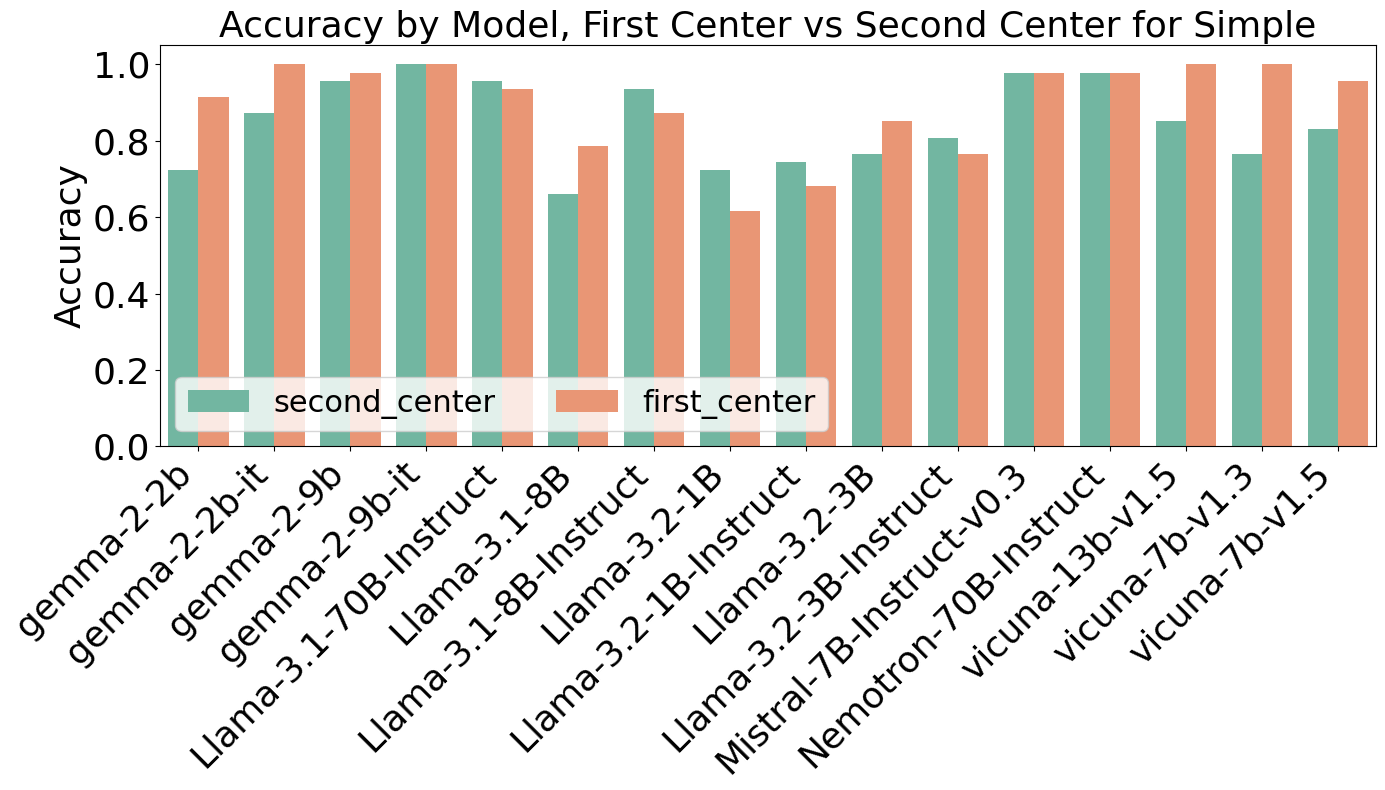

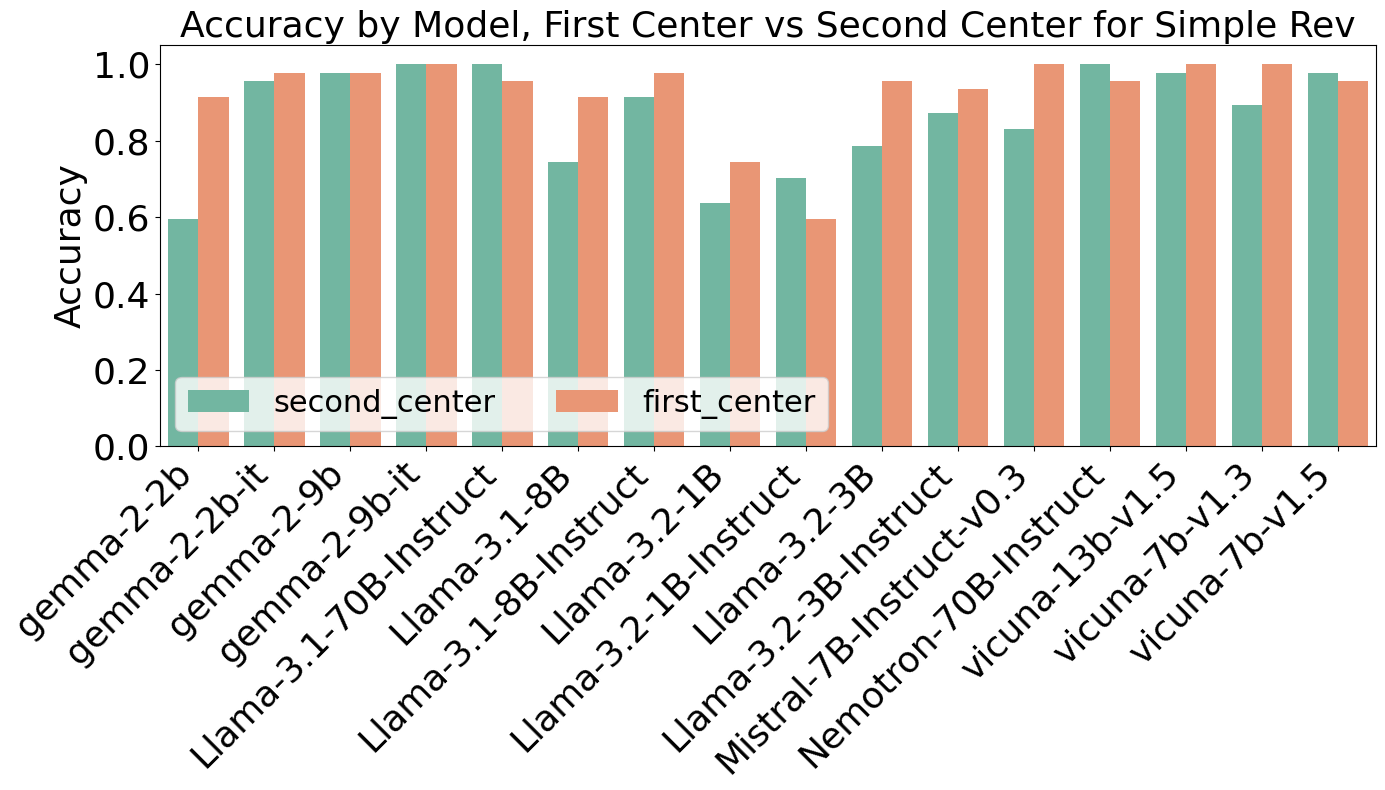

In [ ]:
# Draw accuracy separated by center


def plot_accuracy_per_model(grouped_df, title):

  # Calculate the average accuracy for each model, center type, and suffix
  avg_accuracy = grouped_df.groupby(['model', 'center_type'])['accuracy'].mean().reset_index()
  avg_accuracy = avg_accuracy.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the figure
  plt.figure(figsize=(14, 8))

  # Create the bar plot
  sns.barplot(
      data=avg_accuracy,
      x='model',
      y='accuracy',
      hue='center_type',  # Combining center type and wording for color coding
      palette='Set2'
  )

  # Customize the plot
  plt.title(title, fontsize=26)
  plt.xlabel('')
  plt.ylabel('Accuracy', fontsize=26)
  plt.legend(loc='lower left', fontsize=22, ncols=2)
  plt.xticks(rotation=45, ha='right', fontsize=26)
  plt.yticks(fontsize=26)

  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)

  # Show plot
  plt.tight_layout()
  plt.show()

plot_accuracy_per_model(accuracy_by_model_and_type, 'Accuracy by Center Type Across Models')
com = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "com"]
mid = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "mid"]
sim = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "sim"]
sim_rev = accuracy_by_model_and_type_with_sim_rev[accuracy_by_model_and_type_with_sim_rev['wording'] == "sim_rev"]

plot_accuracy_per_model(com, title='Accuracy by Model, First Center vs Second Center for Complex')
plot_accuracy_per_model(mid, title='Accuracy by Model, First Center vs Second Center for Intermediae')
plot_accuracy_per_model(sim, title='Accuracy by Model, First Center vs Second Center for Simple')
plot_accuracy_per_model(sim_rev, title='Accuracy by Model, First Center vs Second Center for Simple Rev')

In [ ]:
def confidence_first_vs_second(all_data, isRight, wording=None):
  title_suffix = " (First vs Second)"
  if wording:
    all_data=all_data[all_data['wording'] == wording]
    title_suffix = f" {wording}".title()

  # Filter data for correct and incorrect predictions
  prob = 'correct_probability' if isRight else 'incorrect_probability'
  first_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['center_type'] == 'first_center')][['model', prob]]
  second_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['center_type'] == "second_center")][['model', prob]]


  # Rename columns for consistency in plotting
  first_data = first_data.rename(columns={prob: 'probability'})
  second_data = second_data.rename(columns={prob: 'probability'})

  # Add a column indicating the type of probability
  first_data['type'] = 'First'
  second_data['type'] = 'Second'

  # Combine the two datasets
  plot_data = pd.concat([first_data, second_data], ignore_index=True)

  plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the matplotlib figure
  plt.figure(figsize=(12, 8))

  # Create a boxplot
  sns.boxplot(
      data=plot_data,
      x='model',
      y='probability',
      hue='type',
      dodge=True,
      whis=[2,98]
  )
  is_right_title= "Right" if isRight else "Wrong"
  title= 'Confidence - Probability Distributions ' + is_right_title + title_suffix
  plt.title(title)
  plt.xlabel('Model')
  plt.ylabel('Probability')
  plt.legend(title='Type of Probability')
  plt.ylim(-0.05,1.02)
  plt.xticks(rotation=45, ha='right', fontsize=10)


  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)


  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()



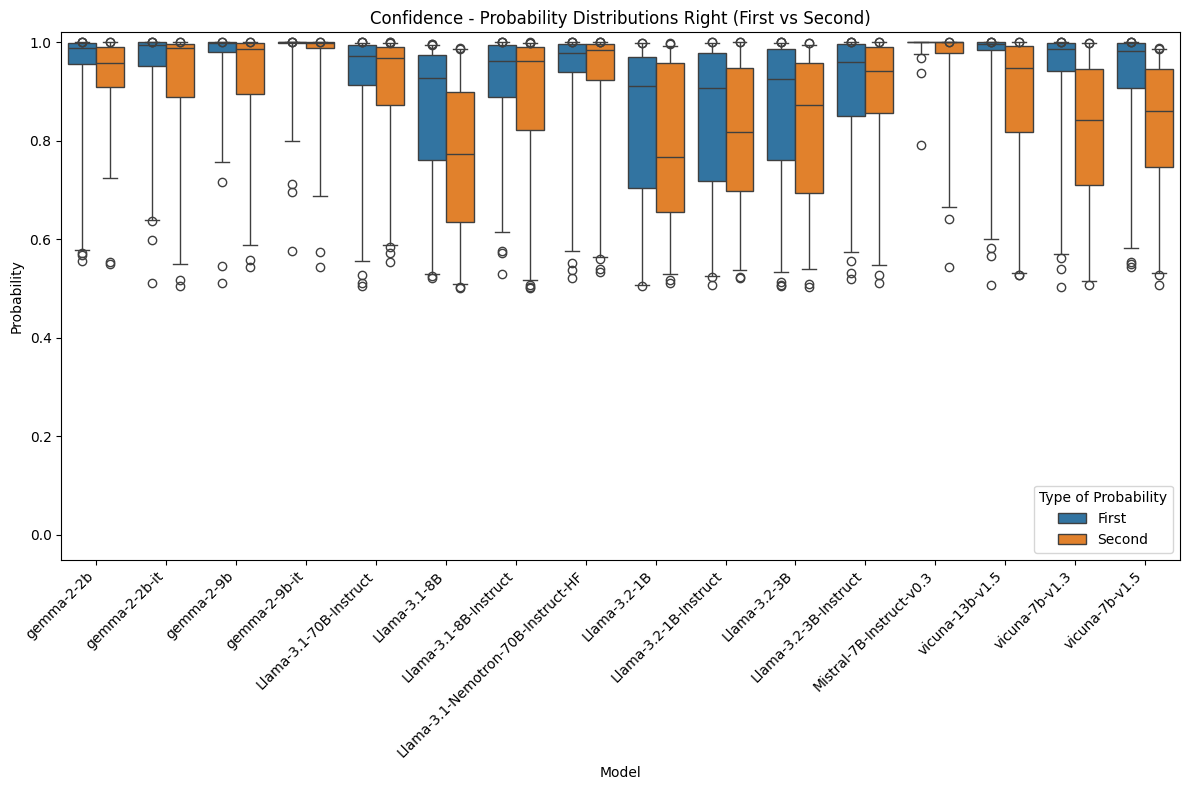

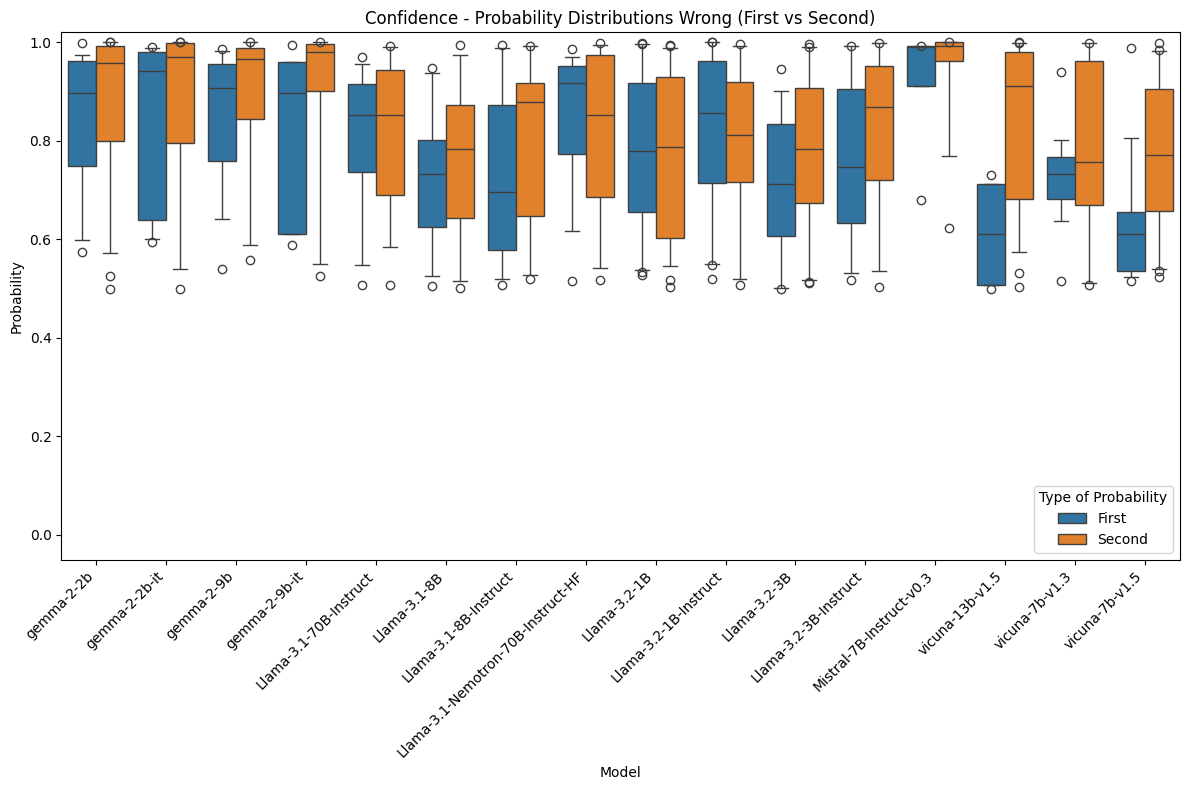

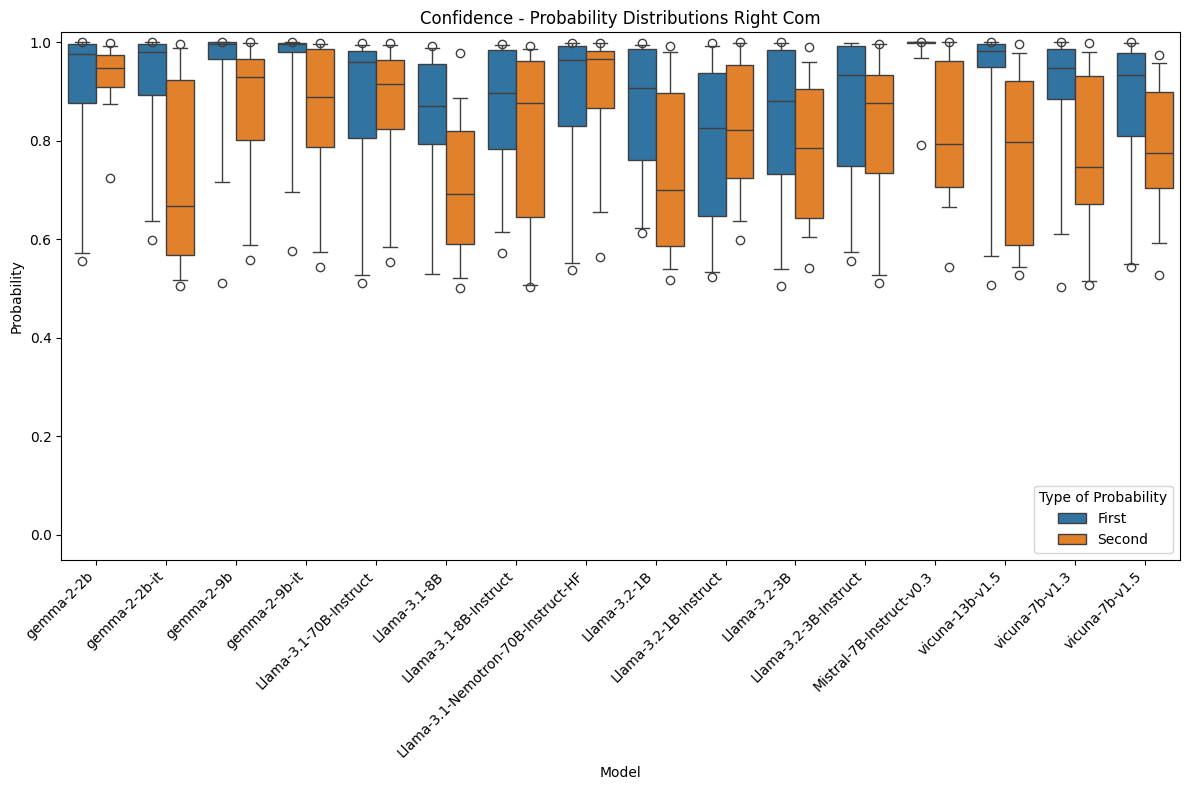

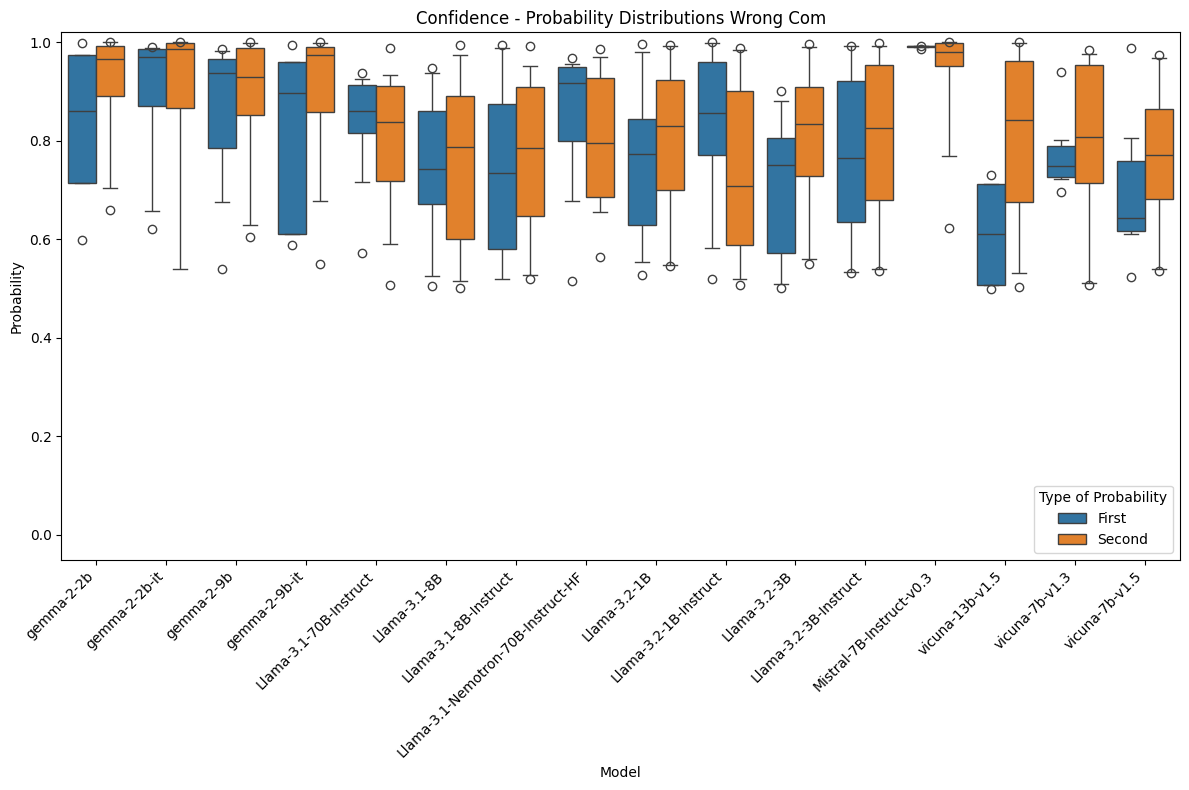

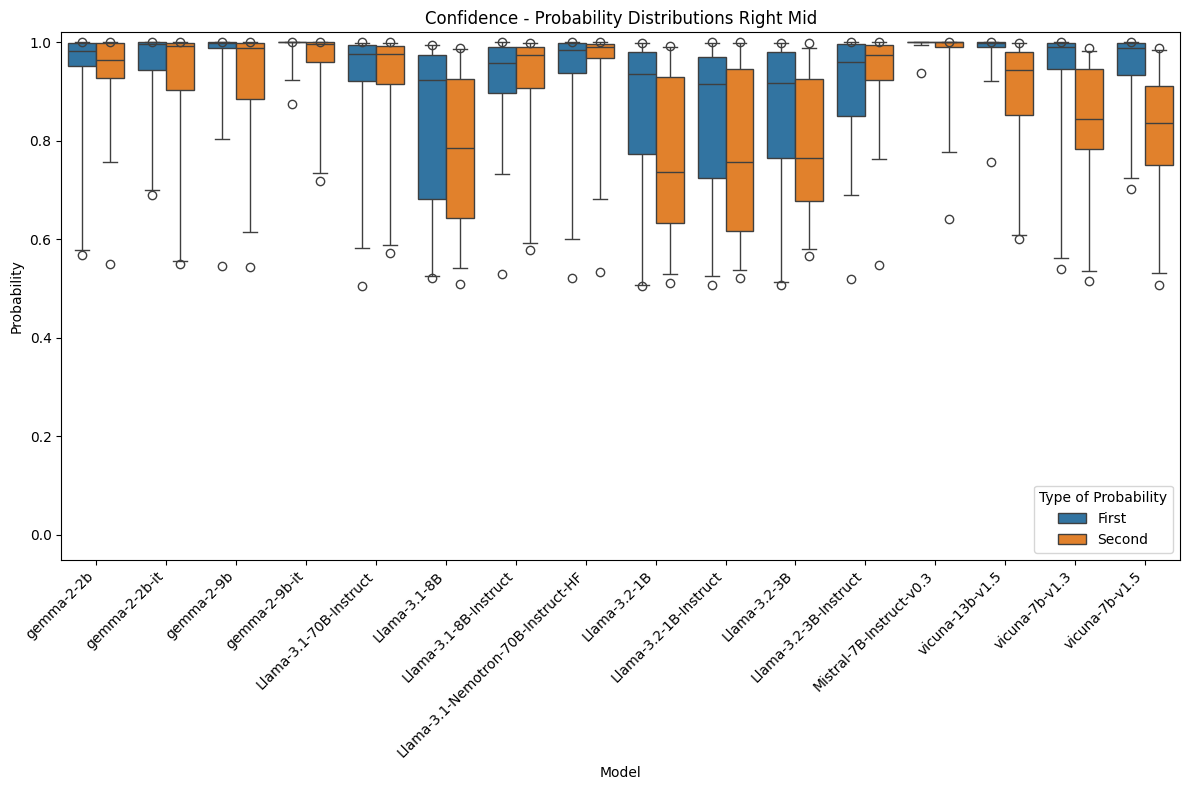

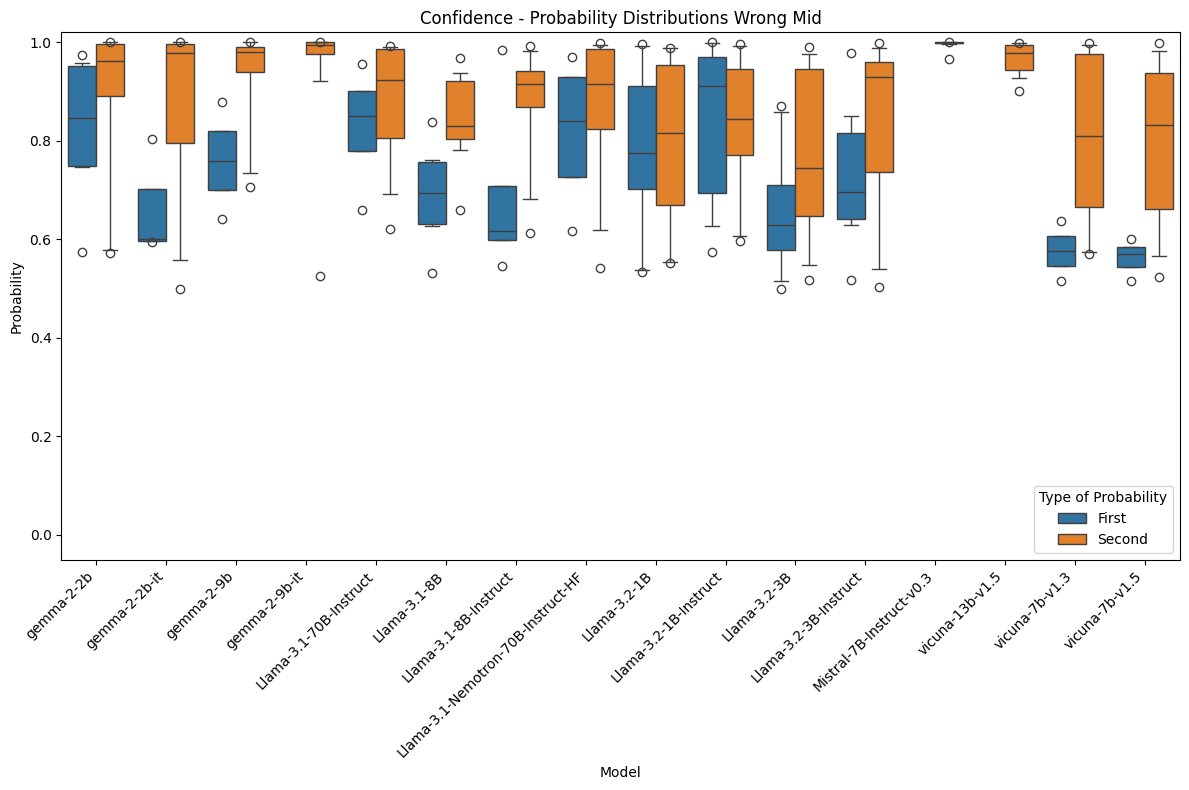

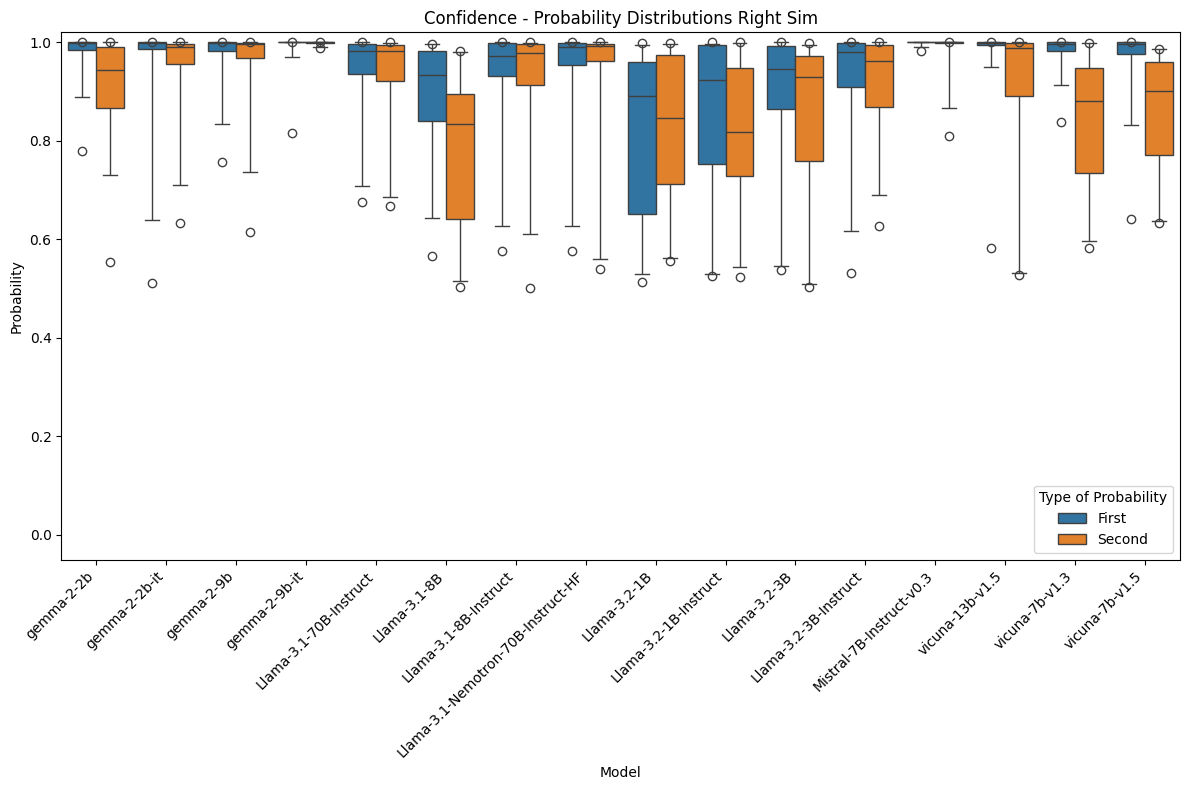

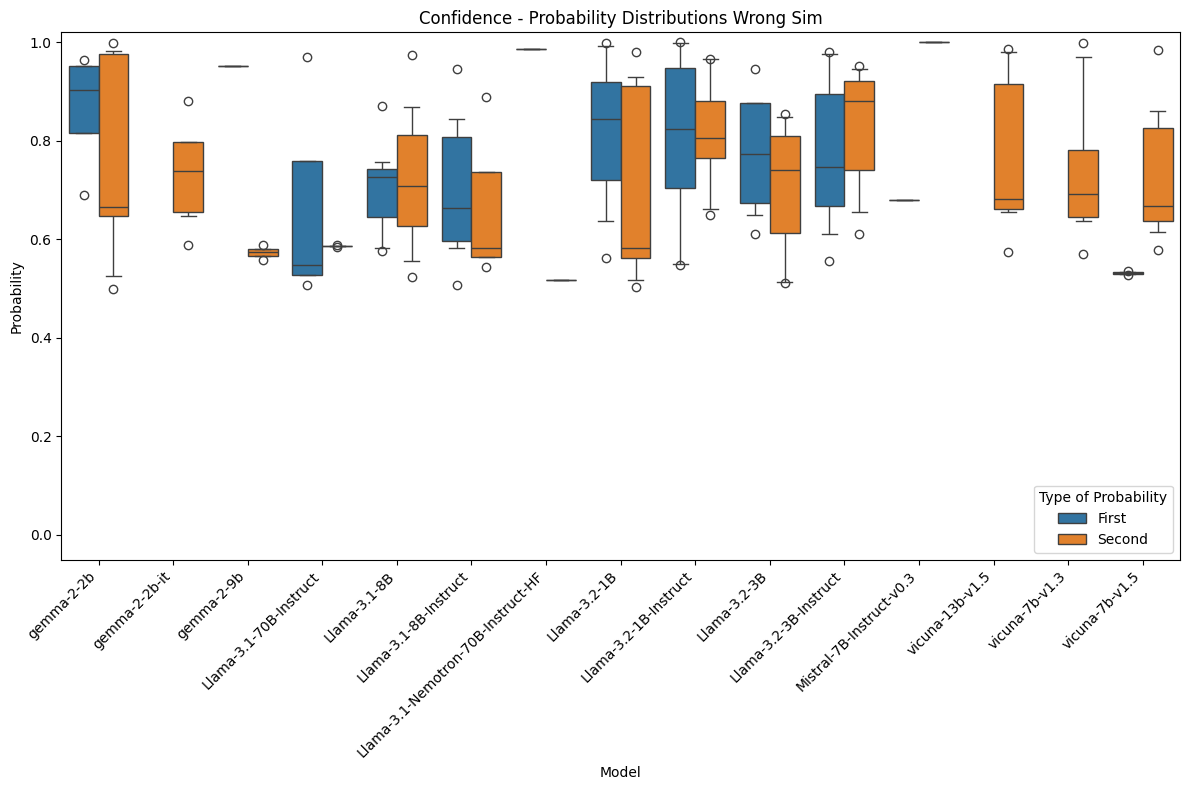

In [ ]:
confidence_first_vs_second(all_data, isRight=True, wording=None)
confidence_first_vs_second(all_data, isRight=False, wording=None)
confidence_first_vs_second(all_data, isRight=True, wording="com")
confidence_first_vs_second(all_data, isRight=False, wording="com")
confidence_first_vs_second(all_data, isRight=True, wording="mid")
confidence_first_vs_second(all_data, isRight=False, wording="mid")
confidence_first_vs_second(all_data, isRight=True, wording="sim")
confidence_first_vs_second(all_data, isRight=False, wording="sim")

## Statistical tests

In [ ]:
def print_to_screen_and_file(file_path, *args, **kwargs):
    # Print to the screen
    print(*args, **kwargs)

    # Open (or create) the file "CCC" in append mode
    with open(file_path + ".txt", "a") as file:
        print(*args, file=file, **kwargs)



In [ ]:
from scipy.stats import mannwhitneyu

def stat_test_com_vs_non_com(df, model_name, file_path):

  print_to_screen_and_file(file_path, f"Model name is: {model_name}")



  for i, t in enumerate(["right_all", "wrong_all", "first_center_right", "first_center_wrong", "second_center_right", "second_center_wrong"]):
      if t == "right_all":
        com = df[(df["wording"] =="com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        non_com = df[(~(df["wording"]=="com")) & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "non com has significantly larger values"
      elif t == "wrong_all":
        com = df[(df["wording"] =="com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        non_com = df[(~(df["wording"]=="com")) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "non com has significantly lower values"
      # For wrong answers
      elif t == "first_center_right":
        com = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        non_com = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "non com has significantly larger values"
      elif t == "first_center_wrong":
        com = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        non_com = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "non com has significantly lower values"
      elif t == "second_center_right":
        com = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        non_com = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "non com has significantly larger values"
      else:
        assert(t == "second_center_wrong")
        com = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        non_com = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "non com has significantly lower values"



      print_to_screen_and_file(file_path, t.replace("_", " "))

      if com.empty or non_com.empty:
        print_to_screen_and_file(file_path, "Not enough data to perform test")
        print_to_screen_and_file(file_path, "")
        continue
      # Perform the Mann-Whitney U Test
      stat, p_value = mannwhitneyu(com, non_com, alternative=alternative)


      # Print the results

      print_to_screen_and_file(file_path, f"U-statistic: {stat}")
      print_to_screen_and_file(file_path, f"P-value: {p_value}")


      # Interpret the results
      alpha = 0.05
      if p_value < alpha:
          print_to_screen_and_file(file_path, f"Reject the null hypothesis: {hypothesis}.")
      else:
          print_to_screen_and_file(file_path, "Fail to reject the null hypothesis: No significant difference.")

      print_to_screen_and_file(file_path, "_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")
      print_to_screen_and_file(file_path, "")

  print_to_screen_and_file(file_path, "________________________________________________________________________")
  print_to_screen_and_file(file_path, "")
      # Optional: Visualize the data
      #plt.hist(com, bins=20, alpha=0.5, label='com')
      #plt.hist(non_com, bins=20, alpha=0.5, label='non_com')
      #plt.legend(loc='upper right')
      #plt.xlabel('Probability')
      #plt.ylabel('Count')
      #plt.title('Distributions Comparison')
      #plt.show()


In [ ]:
file_path = os.path.join(res_dir, f"com_vs_non_com_statistic_test")
for model in all_data['model'].unique():
  stat_test_com_vs_non_com(all_data[all_data['model'] == model], model, file_path)

Model name is: gemma-2-2b
right all
U-statistic: 3018.0
P-value: 0.034661234212514366
Reject the null hypothesis: non com has significantly larger values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

wrong all
U-statistic: 1220.0
P-value: 0.04357977535870708
Reject the null hypothesis: non com has significantly lower values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

first center right
U-statistic: 1290.0
P-value: 0.00431613638406226
Reject the null hypothesis: non com has significantly larger values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

first center wrong
U-statistic: 23.0
P-value: 0.36663336663336665
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

second center right
U-statistic: 231.0
P-value: 0.34849824725398354
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

second center wrong
U-statistic: 842.0
P-value: 0.10721490204188777
Fail to reject the null hypothesis: No significant differe

In [ ]:
from scipy.stats import mannwhitneyu

def stat_test_first_vs_second(df, model_name, file_path):

  print_to_screen_and_file(file_path, f"Model name is: {model_name}")



  for i, t in enumerate(["right_all", "wrong_all", "com_right", "com_wrong", "mid_right", "mid_wrong", "sim_right", "sim_wrong"]):
      if t == "right_all":
        first = df[(df["center_type"] =="first_center") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["center_type"]=="second_center") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      elif t == "wrong_all":
        first = df[(df["center_type"] =="first_center") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["center_type"]=="second_center") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"
      # For wrong answers
      elif t == "com_right":
        first = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      elif t == "com_wrong":
        first = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"
      elif t == "mid_right":
        first = df[(df["type"] == "first_center_mid") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["type"] == "second_center_mid") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      elif t == "mid_wrong":
        first = df[(df["type"] == "first_center_mid") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["type"] == "second_center_mid") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"
      elif t == "sim_right":
        first = df[(df["type"] == "first_center_sim") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["type"] == "second_center_sim") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      else:
        assert(t == "sim_wrong")
        first = df[(df["type"] == "first_center_sim") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["type"] == "second_center_sim") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"



      print_to_screen_and_file(file_path, t.replace("_", " "))

      if first.empty or second.empty:
        print_to_screen_and_file(file_path, "Not enough data to perform test")
        print_to_screen_and_file(file_path, "")
        continue
      # Perform the Mann-Whitney U Test
      #stat, p_value = mannwhitneyu(com, non_com, alternative=alternative)
      stat, p_value = mannwhitneyu(second, first, alternative=alternative)


      # Print the results

      print_to_screen_and_file(file_path, f"U-statistic: {stat}")
      print_to_screen_and_file(file_path, f"P-value: {p_value}")


      # Interpret the results
      alpha = 0.05
      if p_value < alpha:
          print_to_screen_and_file(file_path, f"Reject the null hypothesis: {hypothesis}.")
      else:
          print_to_screen_and_file(file_path, "Fail to reject the null hypothesis: No significant difference.")

      print_to_screen_and_file(file_path, "_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")
      print_to_screen_and_file(file_path, "")

  print_to_screen_and_file(file_path, "________________________________________________________________________")
  print_to_screen_and_file(file_path, "")
      # Optional: Visualize the data
      #plt.hist(com, bins=20, alpha=0.5, label='com')
      #plt.hist(non_com, bins=20, alpha=0.5, label='non_com')
      #plt.legend(loc='upper right')
      #plt.xlabel('Probability')
      #plt.ylabel('Count')
      #plt.title('Distributions Comparison')
      #plt.show()


In [ ]:
file_path = os.path.join(res_dir, f"first_vs_second_statistic_test")
for model in all_data['model'].unique():
  stat_test_first_vs_second(all_data[all_data['model'] == model], model, file_path)

Model name is: gemma-2-2b
right all
U-statistic: 2880.0
P-value: 0.0003104243937560109
Reject the null hypothesis: first center has significantly larger values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

wrong all
U-statistic: 676.5
P-value: 0.054452972428288976
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

com right
U-statistic: 159.0
P-value: 0.20542340563764117
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

com wrong
U-statistic: 96.0
P-value: 0.20167722138944166
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

mid right
U-statistic: 389.0
P-value: 0.18761394599473397
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

mid wrong
U-statistic: 103.0
P-value: 0.08682282987066078
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _



## Download results

In [ ]:
import shutil
from google.colab import files

In [ ]:
# Replace 'folder_path' with the path to the folder you want to download
folder_path = res_dir
zip_file_path = f'/content/results.zip'

# Zip the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
shutil.rmtree(f"/{res_dir}")